# Homework 2 - BME6938
### Winston Chu

### a) Load Dataset

In [1]:
# Load libraries
import pandas as pd
import numpy as np

# Read the file and save to a DataFrame
in_file = "data.csv"
data = pd.read_csv(in_file)
type(data.shape)

# Display results
print('Matrix dimensions: %s' % (data.shape, ))
data.head()

Matrix dimensions: (195, 24)


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654,1
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674,1
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634,1
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975,1
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335,1


#### Preprocessing

In [2]:
# Separate features from class labels
X = data.loc[:, 'MDVP:Fo(Hz)':'PPE'].values
Y = data.loc[:,'status'].values

# Check that there are no duplicate subjects
print('Duplicate subjects?: %s' % any(data['name'].duplicated()))

Duplicate subjects?: False


### b) knn classifier in a holdout + cross-validation
#### Split data into test and train groups

In [3]:
from sklearn.model_selection import train_test_split

#Chose a test size as 10% of total dataset
X_train, X_test, y_train, y_test = \
    train_test_split(X, Y, 
                     test_size=0.10,
                     stratify=Y,
                     random_state=1)

# Output array size to confirm split
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", y_test.shape)

X_train shape:  (175, 22)
Y_train shape:  (175,)
X_test shape:  (20, 22)
Y_test shape:  (20,)


#### Run knn classifier with cross-validation

In [4]:
# Load libraries
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Create KNN pipeline with scaling (default settings)
pipe_knn = make_pipeline(StandardScaler(),
                         KNeighborsClassifier())

# Specify range of k values to test
k_range = [4, 5, 6, 7, 8, 9, 10]
k_range_dict = {'kneighborsclassifier__n_neighbors': k_range}

# Cross validation
gs = GridSearchCV(estimator=pipe_knn, 
                  param_grid=k_range_dict, 
                  cv=10,
                  n_jobs=-1)

gs_calc = gs.fit(X_train, y_train)
print('Best score: %.3f' % gs.best_score_)
print('Best parameter: %s' % gs.best_params_)

Best score: 0.926
Best parameter: {'kneighborsclassifier__n_neighbors': 5}


### c) Plot learning curve & validation curve
Calculate Learning Curves

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_knn,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

Plot Learning Curves

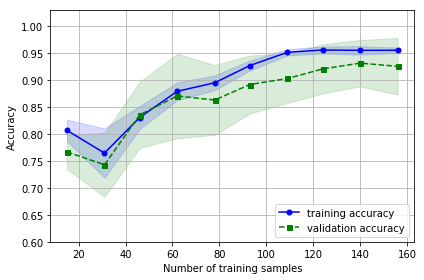

In [6]:
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.6, 1.03])
plt.tight_layout()
plt.show()

Calculate Validation Curves

In [7]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(
                estimator=pipe_knn, 
                X=X_train, 
                y=y_train, 
                param_name='kneighborsclassifier__n_neighbors', 
                param_range=k_range,
                cv=10,
                n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

Plot Validation Curves

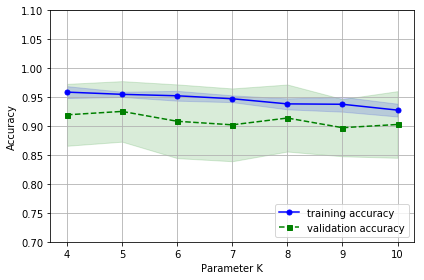

In [8]:
plt.plot(k_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(k_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(k_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(k_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Parameter K')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1.1])
plt.tight_layout()
plt.show()

Confirmed from the validation curve that k=5 has the highest validation accuracy. Interestingly, the training accuracy is not maximized at a k of 5.